In [49]:
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind, pearsonr, chisquare, chi2_contingency
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Preprocessing:

In [50]:
# Initialize an empty list to store DataFrames
dataframes = []

# Iterate over all files matching the pattern
for file in glob.glob("../subject-*-pandasRecall.csv"):
    # Read the CSV file into a DataFrame
    temp_df = pd.read_csv(file)
    
    # Extract the subject number from the filename
    subject_number = os.path.basename(file).split('-')[1].split('.')[0]
    
    # Add a new column for the subject number
    temp_df['subject_number'] = subject_number
    
    # Append the DataFrame to the list
    dataframes.append(temp_df)

# Concatenate all DataFrames into a single DataFrame
all_data = pd.concat(dataframes, ignore_index=True)

# Remove rows with infinite reaction times
all_data = all_data[all_data['rt'] != np.inf]

all_data['subject_number'] = pd.to_numeric(all_data['subject_number'], errors='coerce')

# Select only the data for subject number 3
# all_data = all_data[all_data['subject_number'] == 21]

In [51]:
user_modelling_questionnaire = pd.read_csv("User Modelling Questionnaire.csv")

# Rename the columns
user_modelling_questionnaire = user_modelling_questionnaire.rename(columns={
    "Before we start, please indicate your subject number.": "subject_number",
    "Have you received an official diagnosis of ADHD from a healthcare professional?": "confirmed_ADHD",
    "How often do you have difficulty concentrating on what people are saying to you even when they are speaking to you directly?": "q1",
    "How often do you leave your seat in meetings or other situations in which you are expected to remain seated?": "q2",
    "How often do you have difficulty unwinding and relaxing when you have time to yourself?": "q3",
    "When you’re in a conversation, how often do you find yourself finishing the sentences of the people you are talking to before they can finish them themselves?": "q4",
    "How often do you put things off until the last minute?": "q5",
    "How often do you depend on others to keep your life in order and attend to details?": "q6"
})
# Keep only the renamed columns
user_modelling_questionnaire = user_modelling_questionnaire[["subject_number", "confirmed_ADHD", "q1", "q2", "q3", "q4", "q5", "q6"]]

# Map the answers from confirmed_ADHD to True/False
user_modelling_questionnaire['confirmed_ADHD'] = user_modelling_questionnaire['confirmed_ADHD'].map({'Yes': True, 'No': False})

# Define a mapping from textual answers to numerical values
answer_mapping = {
    "Never": 0,
    "Rarely": 1,
    "Sometimes": 2,
    "Often": 3,
    "Very often": 4
}

# Define a mapping from textual answers to numerical values
# answer_mapping = {
#     "Never": 1,
#     "Rarely": 2,
#     "Sometimes": 3,
#     "Often": 4,
#     "Very often": 5
# }

# Apply the mapping to the relevant columns
for col in ["q1", "q2", "q3", "q4", "q5", "q6"]:
    user_modelling_questionnaire[col] = user_modelling_questionnaire[col].map(answer_mapping)

# Add a new column 'total_points' that sums up the points from q1 to q6
user_modelling_questionnaire['total_points'] = user_modelling_questionnaire[['q1', 'q2', 'q3', 'q4', 'q5', 'q6']].sum(axis=1)

# Add a new column 'unconfirmed_ADHD' based on the 'total_points' column
user_modelling_questionnaire['unconfirmed_ADHD'] = user_modelling_questionnaire['total_points'] >= 14


In [52]:
# Read the CSV file into a DataFrame
subject_words_timebar = pd.read_csv('subject_words_timebar.csv')

# Select only the necessary columns from subject_words_timebar
subject_words_timebar_reduced = subject_words_timebar[['subject_number', 'question', 'answer', 'time_bar_visible']]

# Merge all_data and subject_words_timebar_reduced on subject_number, prompt (question), and answer
combined_data = pd.merge(all_data, subject_words_timebar_reduced, how='inner', left_on=['subject_number', 'prompt', 'answer'], right_on=['subject_number', 'question', 'answer'])

# Drop the 'question' column as it is redundant now
combined_data = combined_data.drop(columns=['question'])

# Merge the combined_data with user_modelling_questionnaire on 'subject_number'
combined_data = pd.merge(combined_data, user_modelling_questionnaire[['subject_number', 'total_points']], on='subject_number', how='left')

# Display the updated combined_data
combined_data.head()

,Unnamed: 0,trial_num,trial_start_time,rt,correct,prompt,answer,response,subject_number,time_bar_visible,total_points
0,0,1,20729.6109,5786.4230,False,maliki,king,chair,20,False,9
1,1,2,29857.2150,5373.3904,False,ajabu,wonder,chair,20,False,9
2,2,3,38522.4829,1347.0916,True,lugha,language,language,20,False,9
3,3,4,44376.1938,2884.9703,True,kiti,chair,chair,20,False,9
4,4,5,50384.9036,1819.8801,True,sauti,voice,voice,20,False,9


# First calculate the results for each subject and show them in a boxplot:

In [53]:
# Group by 'subject_number' and 'time_bar_visible' and calculate additional statistics
evals = combined_data.groupby(['subject_number', 'time_bar_visible']).agg(
    accuracy=('correct', 'mean'),
    mean_rt=('rt', 'mean'),
    std_rt=('rt', 'std'),
    median_rt=('rt', 'median'),
    trial_count=('trial_num', 'count'),
    total_points=('total_points', 'first')
).reset_index()

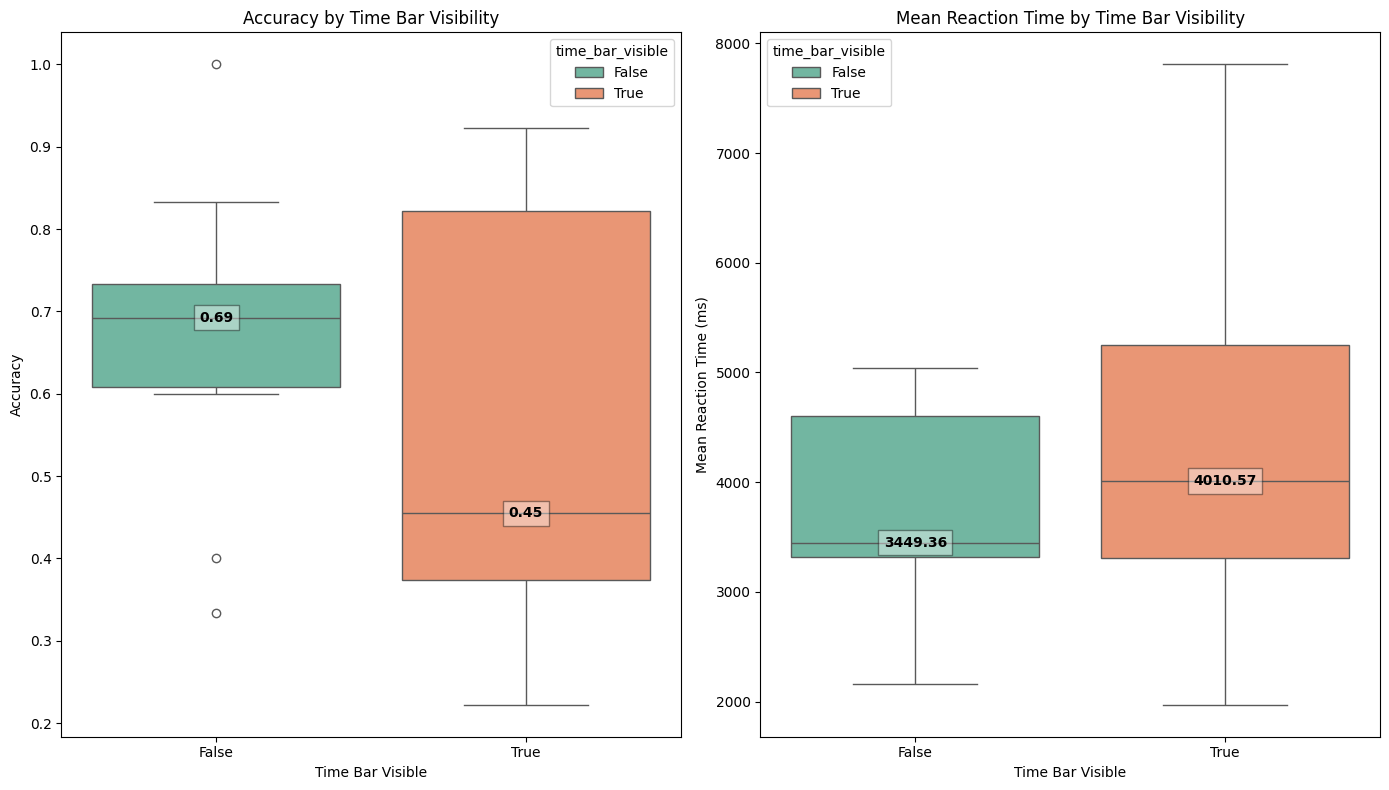

In [54]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Plot accuracy
sns.boxplot(ax=axes[0], x='time_bar_visible', y='accuracy', data=evals, palette='Set2', hue='time_bar_visible')
axes[0].set_title('Accuracy by Time Bar Visibility')
axes[0].set_xlabel('Time Bar Visible')
axes[0].set_ylabel('Accuracy')

# Calculate and add median values for accuracy
median_accuracy = evals.groupby('time_bar_visible')['accuracy'].median()
for i, median in enumerate(median_accuracy):
    axes[0].text(i, median, f'{median:.2f}', ha='center', va='center', color='black', fontweight='bold', bbox=dict(facecolor='white', alpha=0.4))

# Plot mean reaction time
sns.boxplot(ax=axes[1], x='time_bar_visible', y='mean_rt', data=evals, palette='Set2', hue='time_bar_visible')
axes[1].set_title('Mean Reaction Time by Time Bar Visibility')
axes[1].set_xlabel('Time Bar Visible')
axes[1].set_ylabel('Mean Reaction Time (ms)')

# Calculate and add median values for mean reaction time
median_rt = evals.groupby('time_bar_visible')['mean_rt'].median()
for i, median in enumerate(median_rt):
    axes[1].text(i, median, f'{median:.2f}', ha='center', va='center', color='black', fontweight='bold', bbox=dict(facecolor='white', alpha=0.4))

# Show the plots
plt.tight_layout()
plt.show()

# accuracy and reaction time over all trials:

If you want to show only the results for 1 participants, uncomment the following code:

In [55]:
# Filter the DataFrame to include only rows where 'subject_number' is X
# filtered_data = filtered_data[filtered_data['subject_number'] == 3]

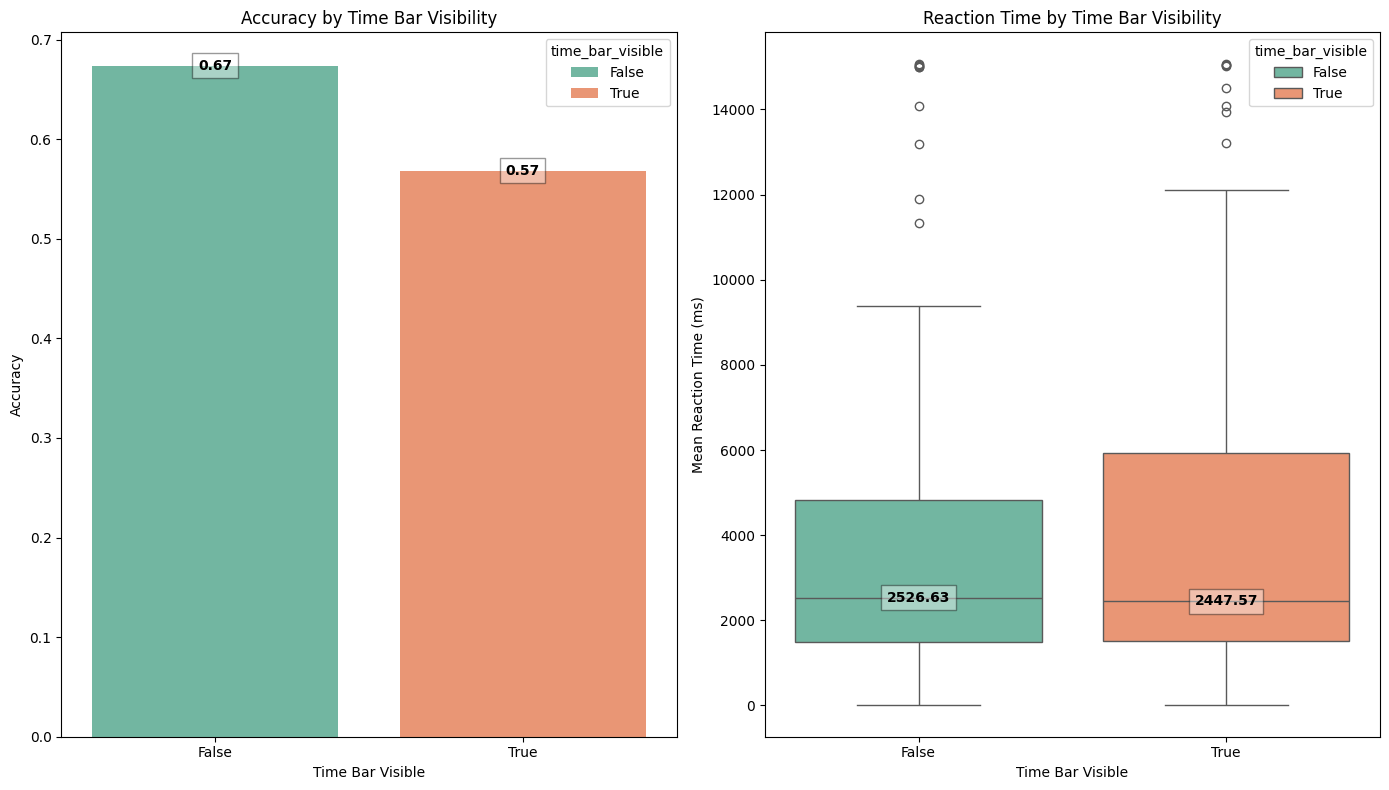

In [56]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Plot accuracy as a barplot
sns.barplot(ax=axes[0], x='time_bar_visible', y='correct', data=combined_data, palette='Set2', hue='time_bar_visible', errorbar=None)
axes[0].set_title('Accuracy by Time Bar Visibility')
axes[0].set_xlabel('Time Bar Visible')
axes[0].set_ylabel('Accuracy')

# Calculate and add median values for accuracy
median_accuracy = combined_data.groupby('time_bar_visible')['correct'].mean()
for i, median in enumerate(median_accuracy):
    axes[0].text(i, median, f'{median:.2f}', ha='center', va='center', color='black', fontweight='bold', bbox=dict(facecolor='white', alpha=0.4))

# Plot mean reaction time
sns.boxplot(ax=axes[1], x='time_bar_visible', y='rt', data=combined_data, palette='Set2', hue='time_bar_visible')
axes[1].set_title('Reaction Time by Time Bar Visibility')
axes[1].set_xlabel('Time Bar Visible')
axes[1].set_ylabel('Mean Reaction Time (ms)')

# Calculate and add median values for mean reaction time
median_rt = combined_data.groupby('time_bar_visible')['rt'].median()
for i, median in enumerate(median_rt):
    axes[1].text(i, median, f'{median:.2f}', ha='center', va='center', color='black', fontweight='bold', bbox=dict(facecolor='white', alpha=0.4))

# Show the plots
plt.tight_layout()
plt.show()

# t-test: first calculate metrics within subject:

In [57]:
from scipy.stats import ttest_ind

# Separate the data based on the time_bar_visible condition
data_time_bar_visible_true = evals[evals['time_bar_visible'] == True]
data_time_bar_visible_false = evals[evals['time_bar_visible'] == False]

# Perform t-test for accuracy
t_stat_accuracy, p_value_accuracy = ttest_ind(data_time_bar_visible_true['accuracy'], data_time_bar_visible_false['accuracy'])

# Perform t-test for mean reaction time
t_stat_mean_rt, p_value_mean_rt = ttest_ind(data_time_bar_visible_true['mean_rt'], data_time_bar_visible_false['mean_rt'])

print(f"Number of subjects with time bar visible: {len(data_time_bar_visible_true)}")
print(f"Number of subjects with time bar not visible: {len(data_time_bar_visible_false)}")

print(f"T-test for Accuracy: t-statistic = {t_stat_accuracy}, p-value = {p_value_accuracy}")
print(f"T-test for Mean Reaction Time: t-statistic = {t_stat_mean_rt}, p-value = {p_value_mean_rt}")

Number of subjects with time bar visible: 11
Number of subjects with time bar not visible: 11
T-test for Accuracy: t-statistic = -1.1431413104278223, p-value = 0.26647961059965314
T-test for Mean Reaction Time: t-statistic = 1.022320245173808, p-value = 0.31883688708238694


# t-test over all trials:

In [58]:
# Separate the data based on the time_bar_visible condition
data_time_bar_visible_true = combined_data[combined_data['time_bar_visible'] == True]
data_time_bar_visible_false = combined_data[combined_data['time_bar_visible'] == False]

# Perform t-test for accuracy
t_stat_accuracy, p_value_accuracy = ttest_ind(data_time_bar_visible_true['correct'], data_time_bar_visible_false['correct'])

# Perform t-test for mean reaction time
t_stat_mean_rt, p_value_mean_rt = ttest_ind(data_time_bar_visible_true['rt'], data_time_bar_visible_false['rt'])

print(f"Number of trials with time bar visible: {len(data_time_bar_visible_true)}")
print(f"Number of trials with time bar not visible: {len(data_time_bar_visible_false)}")

print(f"T-test for Accuracy: t-statistic = {t_stat_accuracy}, p-value = {p_value_accuracy}")
print(f"T-test for Mean Reaction Time: t-statistic = {t_stat_mean_rt}, p-value = {p_value_mean_rt}")

Number of trials with time bar visible: 139
Number of trials with time bar not visible: 144
T-test for Accuracy: t-statistic = -1.8300100340289573, p-value = 0.06830770765320679
T-test for Mean Reaction Time: t-statistic = 1.2953011425642775, p-value = 0.19627949252025464


# number of correct and incorrect answer for each condition. (number are first calculated within subject)

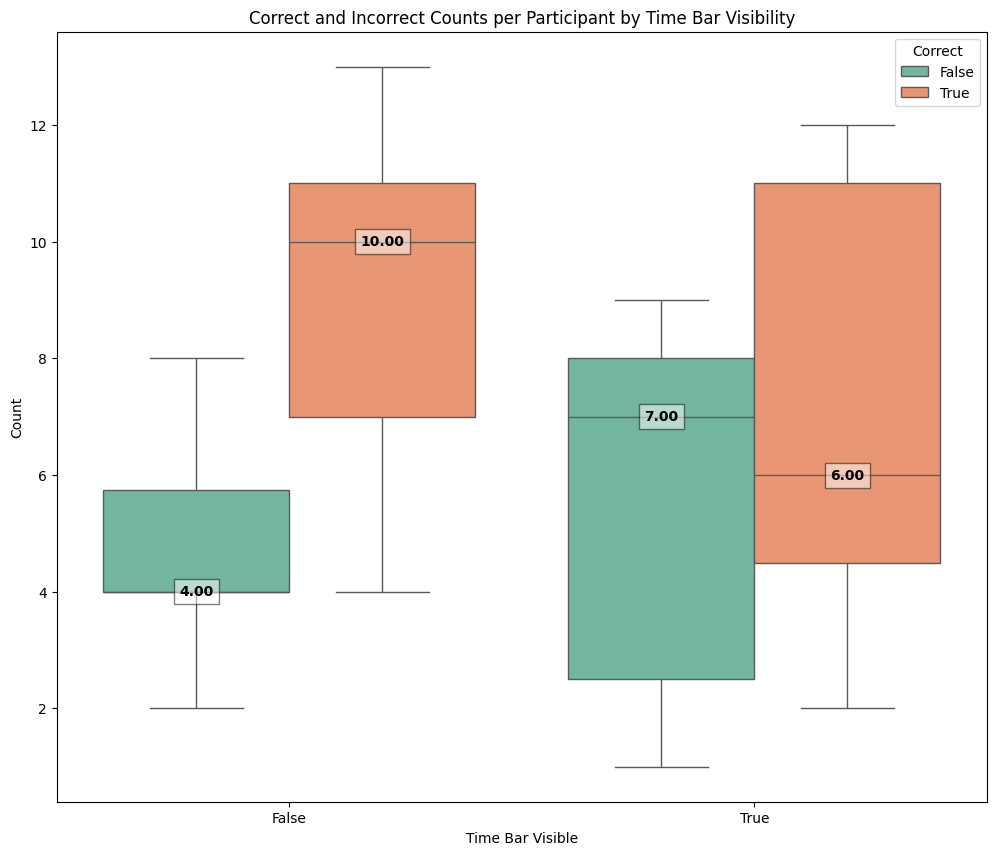

In [59]:
# Group by 'subject_number', 'time_bar_visible', and 'correct' and count the occurrences
correct_incorrect_count_per_participant = combined_data.groupby(['subject_number', 'time_bar_visible', 'correct']).size().reset_index(name='count')

# Create a boxplot for correct_incorrect_count_per_participant
plt.figure(figsize=(12, 10))
sns.boxplot(x='time_bar_visible', y='count', hue='correct', data=correct_incorrect_count_per_participant, palette='Set2')
plt.title('Correct and Incorrect Counts per Participant by Time Bar Visibility')
plt.xlabel('Time Bar Visible')
plt.ylabel('Count')
plt.legend(title='Correct')

# Calculate and add mean values for each group
mean_counts = correct_incorrect_count_per_participant.groupby(['time_bar_visible', 'correct'])['count'].median().reset_index()
for i, row in mean_counts.iterrows():
    x_coord = i // 2 + (i % 2) * 0.2  # Adjust x-coordinate calculation
    if i in [0, 2]:
        x_coord -= 0.2
    plt.text(x_coord, row['count'], f'{row["count"]:.2f}', ha='center', va='center', color='black', fontweight='bold', bbox=dict(facecolor='white', alpha=0.5))

plt.show()


# Overall correct and incorrect answer per condition

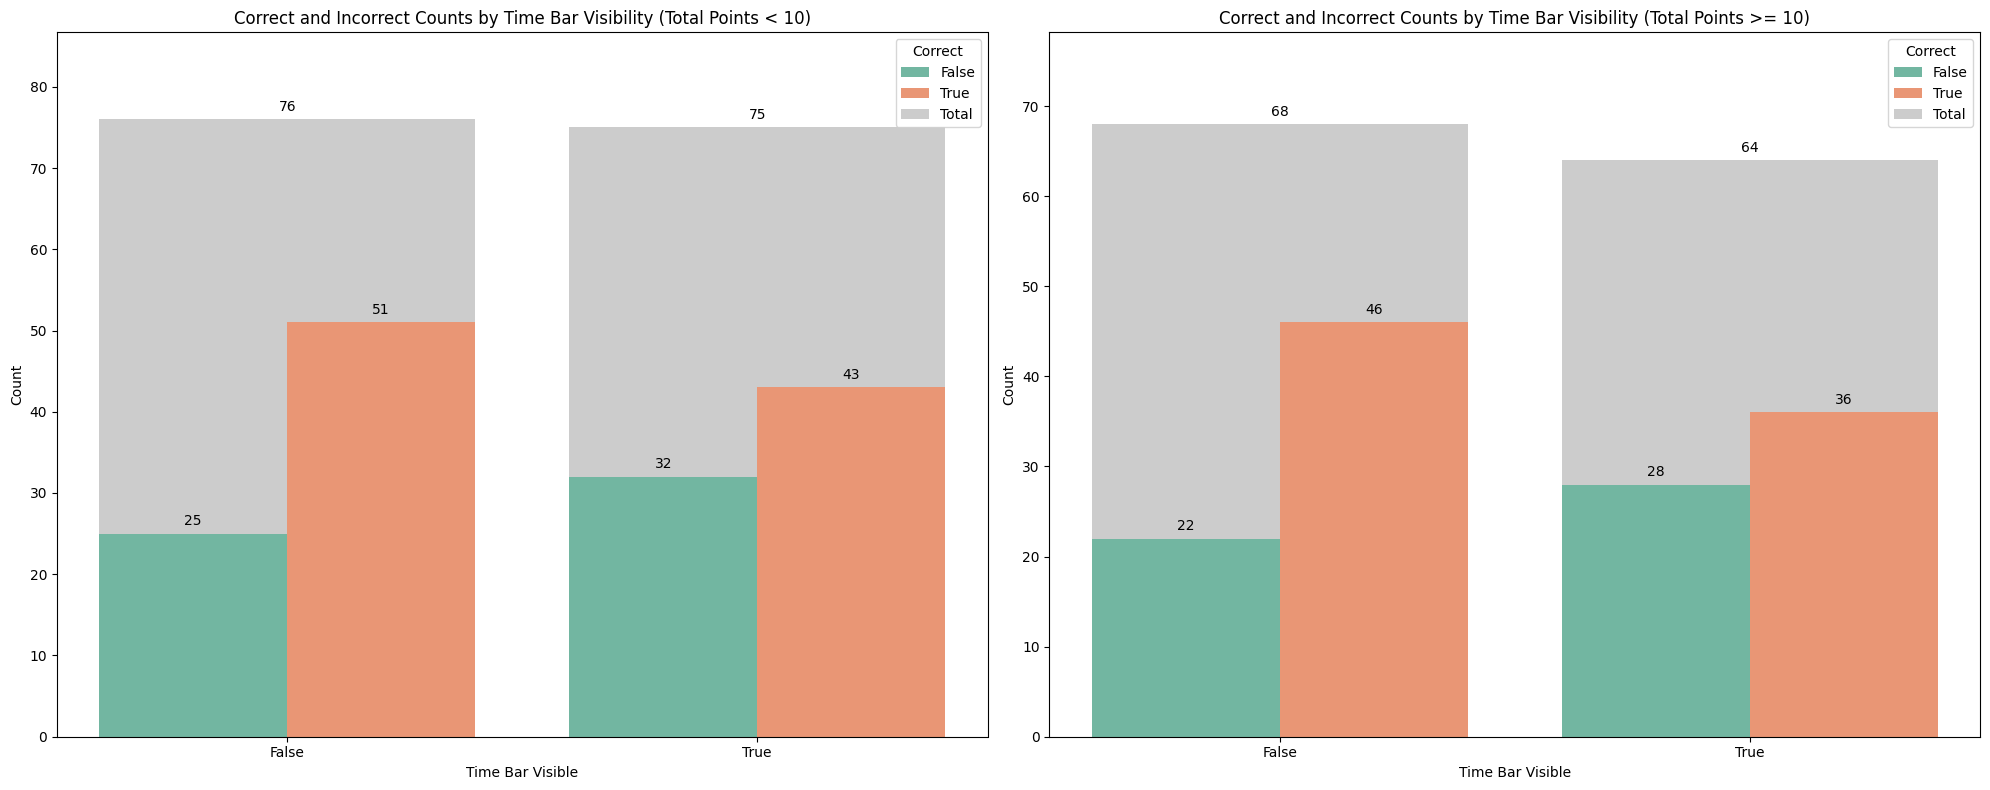

In [60]:
# Filter the data based on total_points
data_less_than_10 = combined_data[combined_data['total_points'] < 10]
data_10_or_more = combined_data[combined_data['total_points'] >= 10]

# Function to create the plot
def plot_correct_incorrect(data, title, ax):
    # Group by 'time_bar_visible' and 'correct' and count the occurrences
    correct_incorrect_count = data.groupby(['time_bar_visible', 'correct']).size().reset_index(name='count')

    # Calculate the number of items for each condition
    num_items_per_condition = data.groupby(['time_bar_visible']).size().reset_index(name='num_items')

    # Plot the original barplot
    barplot = sns.barplot(ax=ax, x='time_bar_visible', y='count', hue='correct', data=correct_incorrect_count, palette='Set2')
    ax.set_title(title)
    ax.set_xlabel('Time Bar Visible')
    ax.set_ylabel('Count')
    ax.legend(title='Correct')

    # Add num_items_per_condition as an extra bar for each condition
    for i, row in num_items_per_condition.iterrows():
        ax.bar(row['time_bar_visible'], row['num_items'], color='grey', alpha=0.4, label='Total' if i == 0 else "", zorder=0)

    # Add numbers on top of each bar
    for p in barplot.patches:
        if p.get_height() > 0:  # Only annotate bars with height greater than 0
            barplot.annotate(format(p.get_height(), '.0f'), 
                             (p.get_x() + p.get_width() / 2., p.get_height()), 
                             ha='center', va='center', 
                             xytext=(0, 9), 
                             textcoords='offset points')

    # Add padding to the top of the graph
    max_count = correct_incorrect_count['count'].max()
    ax.set_ylim(0, max_count * 1.7)  # Extend the upper limit by 70%

    # Update the legend to include 'Total Items' only once
    handles, labels = ax.get_legend_handles_labels()
    if 'Total' not in labels:
        handles.append(plt.Rectangle((0, 0), 1, 1, color='grey', alpha=0.4))
        labels.append('Total')
    ax.legend(handles=handles, labels=labels, title='Correct')

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot for subjects with less than 10 total_points
plot_correct_incorrect(data_less_than_10, 'Correct and Incorrect Counts by Time Bar Visibility (Total Points < 10)', axes[0])

# Plot for subjects with 10 or more total_points
plot_correct_incorrect(data_10_or_more, 'Correct and Incorrect Counts by Time Bar Visibility (Total Points >= 10)', axes[1])

plt.tight_layout()
plt.show()


In [61]:
# Create a contingency table
contingency_table = pd.crosstab([combined_data['total_points'] >= 10, combined_data['time_bar_visible']], combined_data['correct'])

# Perform the chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)


Chi-Square Statistic: 3.354765471765775
p-value: 0.3400927571532588
Degrees of Freedom: 3
Expected Frequencies:
[[28.73498233 47.26501767]
 [28.35689046 46.64310954]
 [25.71024735 42.28975265]
 [24.19787986 39.80212014]]


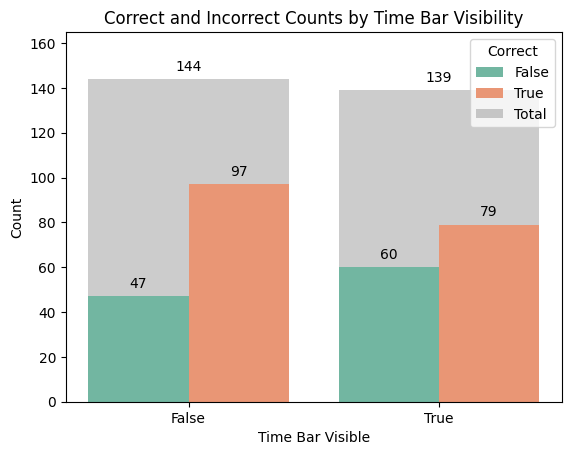

In [62]:
# Use the previously defined function to plot the correct and incorrect counts by time bar visibility
plot_correct_incorrect(combined_data, 'Correct and Incorrect Counts by Time Bar Visibility', plt.gca())
plt.show()


# ADHD:

Correlation between accuracy and total_points: -0.29320530500857356
Pearson correlation: -0.2932053050085736, p-value: 0.3815439347687296


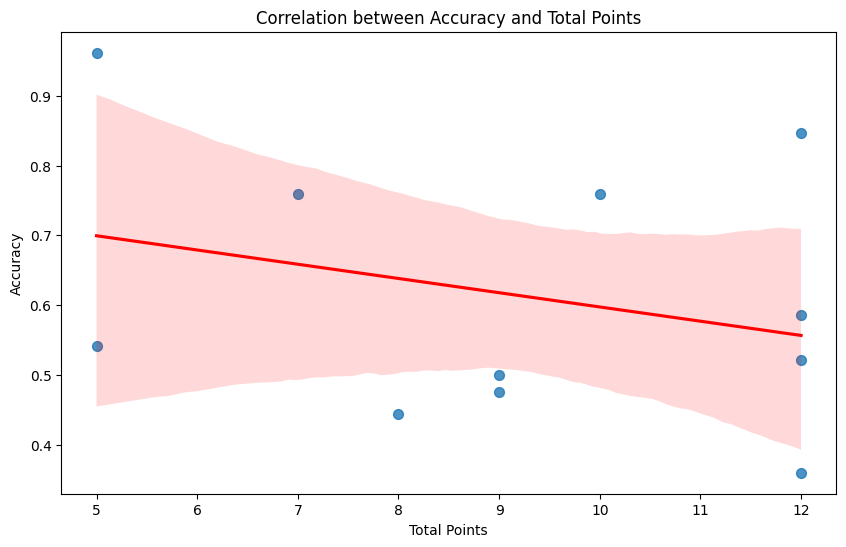

In [63]:
# Calculate the accuracy for each subject for all trials
accuracy_per_subject = combined_data.groupby('subject_number')['correct'].mean().reset_index()
accuracy_per_subject.columns = ['subject_number', 'accuracy']

# Merge accuracy_per_subject with user_modelling_questionnaire to add total_points
accuracy_per_subject = pd.merge(accuracy_per_subject, user_modelling_questionnaire[['subject_number', 'total_points']], on='subject_number', how='left')

# Calculate the correlation between accuracy and total_points
correlation = accuracy_per_subject['accuracy'].corr(accuracy_per_subject['total_points'])
print(f"Correlation between accuracy and total_points: {correlation}")

# Alternatively, using scipy's pearsonr function
pearson_corr, p_value = pearsonr(accuracy_per_subject['accuracy'], accuracy_per_subject['total_points'])
print(f"Pearson correlation: {pearson_corr}, p-value: {p_value}")

# Plot the correlation
plt.figure(figsize=(10, 6))
sns.regplot(x='total_points', y='accuracy', data=accuracy_per_subject, scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.title('Correlation between Accuracy and Total Points')
plt.xlabel('Total Points')
plt.ylabel('Accuracy')
plt.show()

Correlation between accuracy and total_points (time_bar_visible=True): -0.3421373986565955
Pearson correlation (time_bar_visible=True): -0.3421373986565954, p-value: 0.30306188372463155
Correlation between accuracy and total_points (time_bar_visible=False): -0.18122301334784632
Pearson correlation (time_bar_visible=False): -0.1812230133478463, p-value: 0.5938475615325409


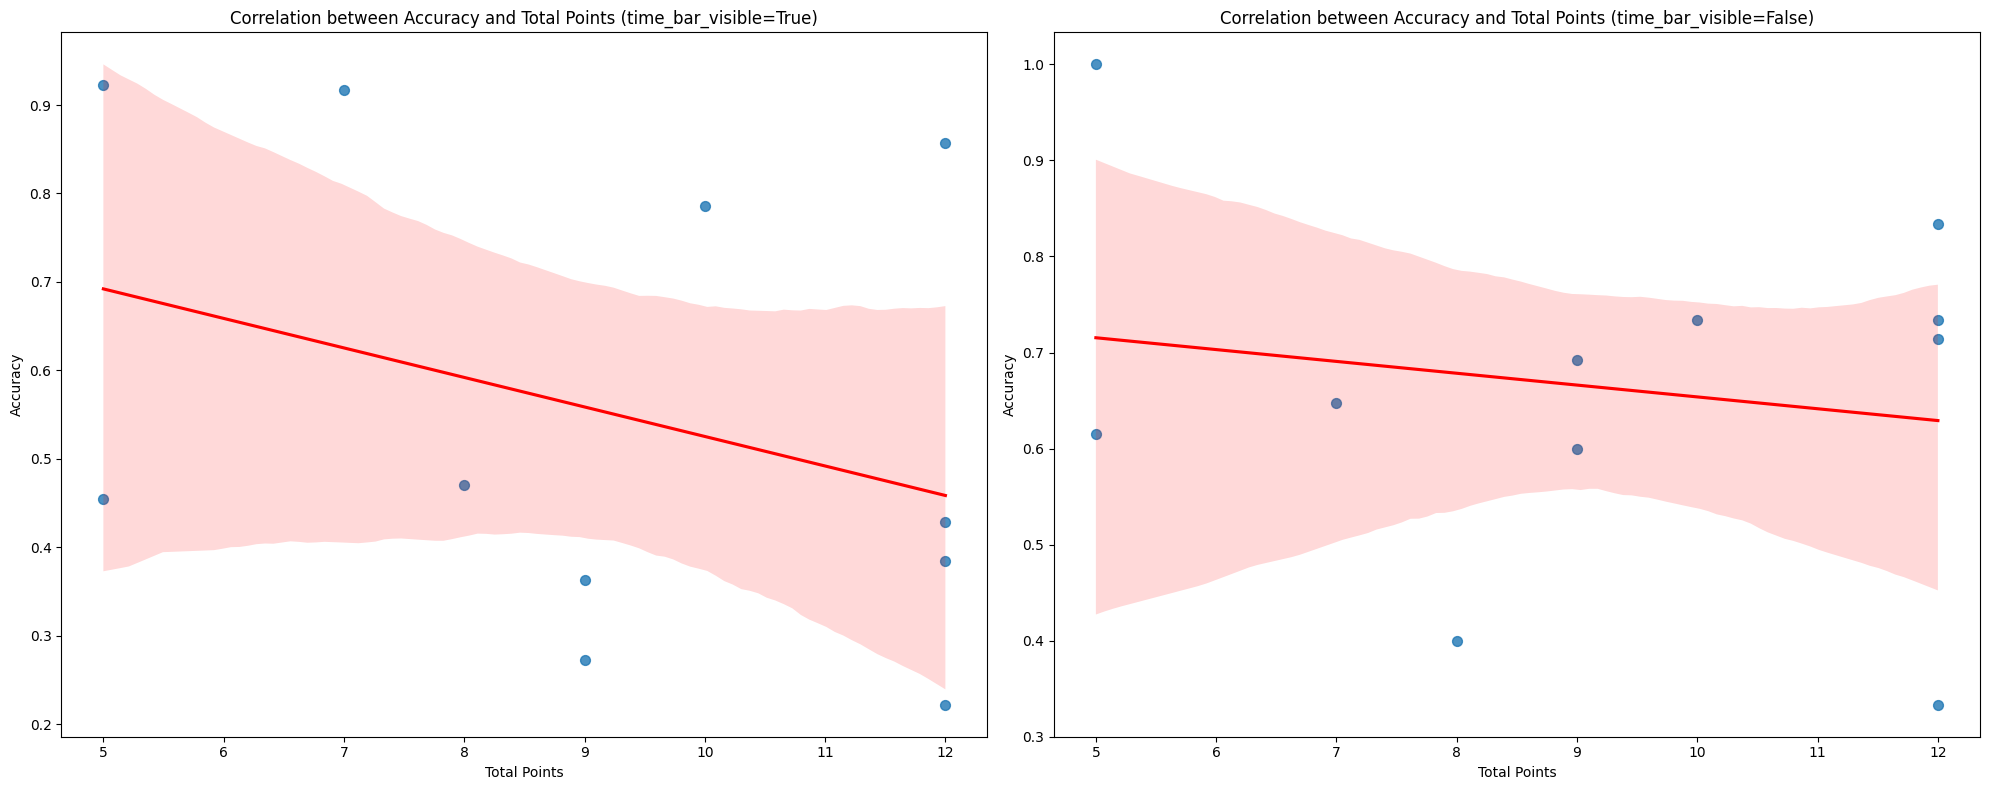

In [64]:
# Calculate the correlation between accuracy and total_points for time_bar_visible = True
correlation_true = evals[evals['time_bar_visible'] == True]['accuracy'].corr(evals[evals['time_bar_visible'] == True]['total_points'])
print(f"Correlation between accuracy and total_points (time_bar_visible=True): {correlation_true}")

# Alternatively, using scipy's pearsonr function
pearson_corr_true, p_value_true = pearsonr(evals[evals['time_bar_visible'] == True]['accuracy'], evals[evals['time_bar_visible'] == True]['total_points'])
print(f"Pearson correlation (time_bar_visible=True): {pearson_corr_true}, p-value: {p_value_true}")

# Calculate the correlation between accuracy and total_points for time_bar_visible = False
correlation_false = evals[evals['time_bar_visible'] == False]['accuracy'].corr(evals[evals['time_bar_visible'] == False]['total_points'])
print(f"Correlation between accuracy and total_points (time_bar_visible=False): {correlation_false}")

# Alternatively, using scipy's pearsonr function
pearson_corr_false, p_value_false = pearsonr(evals[evals['time_bar_visible'] == False]['accuracy'], evals[evals['time_bar_visible'] == False]['total_points'])
print(f"Pearson correlation (time_bar_visible=False): {pearson_corr_false}, p-value: {p_value_false}")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot the correlation for time_bar_visible = True
sns.regplot(ax=axes[0], x='total_points', y='accuracy', data=evals[evals['time_bar_visible'] == True], scatter_kws={'s': 50}, line_kws={'color': 'red'})
axes[0].set_title('Correlation between Accuracy and Total Points (time_bar_visible=True)')
axes[0].set_xlabel('Total Points')
axes[0].set_ylabel('Accuracy')

# Plot the correlation for time_bar_visible = False
sns.regplot(ax=axes[1], x='total_points', y='accuracy', data=evals[evals['time_bar_visible'] == False], scatter_kws={'s': 50}, line_kws={'color': 'red'})
axes[1].set_title('Correlation between Accuracy and Total Points (time_bar_visible=False)')
axes[1].set_xlabel('Total Points')
axes[1].set_ylabel('Accuracy')

# Show the plots
plt.tight_layout()
plt.show()

Correlation between answer length and accuracy: -0.021356819079768077


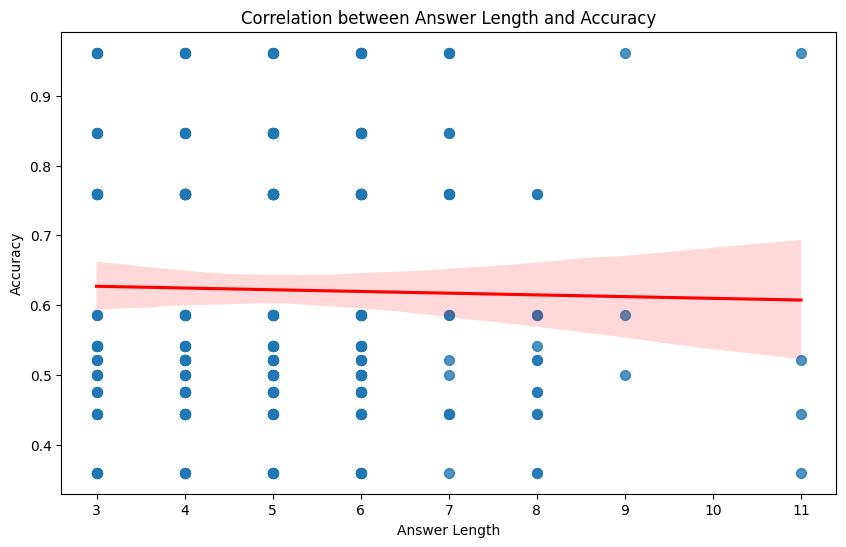

In [65]:
# Calculate the length of each answer
combined_data['answer_length'] = combined_data['answer'].apply(lambda x: len(str(x)))

# Calculate the accuracy for each subject
accuracy_per_subject = combined_data.groupby('subject_number')['correct'].mean().reset_index()
accuracy_per_subject.columns = ['subject_number', 'accuracy']

# Merge the answer length data with the accuracy data
answer_length_accuracy = pd.merge(combined_data[['subject_number', 'answer_length']], accuracy_per_subject, on='subject_number', how='left')

# Calculate the correlation between answer length and accuracy
correlation_length_accuracy = answer_length_accuracy['answer_length'].corr(answer_length_accuracy['accuracy'])
print(f"Correlation between answer length and accuracy: {correlation_length_accuracy}")

# Plot the correlation
plt.figure(figsize=(10, 6))
sns.regplot(x='answer_length', y='accuracy', data=answer_length_accuracy, scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.title('Correlation between Answer Length and Accuracy')
plt.xlabel('Answer Length')
plt.ylabel('Accuracy')
plt.show()

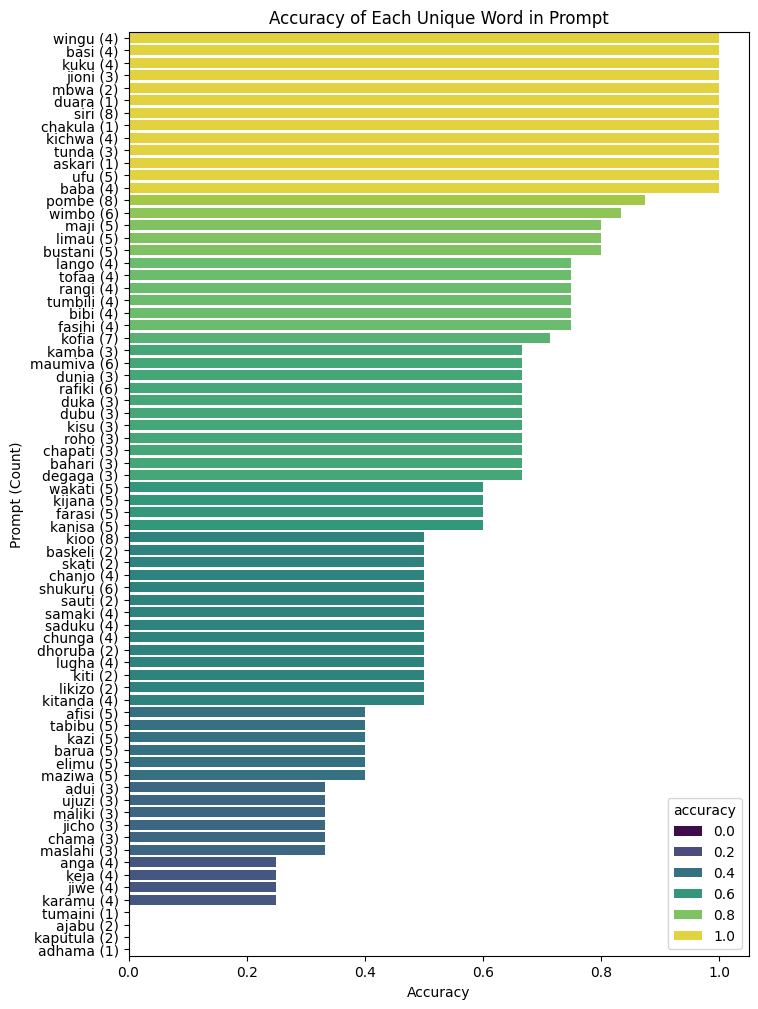

In [66]:
# Group by 'prompt' and calculate the mean accuracy and count of each word in 'prompt'
accuracy_per_prompt = combined_data.groupby('prompt').agg(
    accuracy=('correct', 'mean'),
    count=('prompt', 'size')
).reset_index()

# Sort the data by accuracy for better visualization
accuracy_per_prompt = accuracy_per_prompt.sort_values(by='accuracy', ascending=False)

# Plot the accuracy for each unique word in 'prompt'
plt.figure(figsize=(8, 12))
sns.barplot(x='accuracy', y='prompt', data=accuracy_per_prompt, palette='viridis', orient='h', hue='accuracy')

# Add the count of occurrences to the y-axis labels
plt.yticks(ticks=range(len(accuracy_per_prompt)), labels=[f"{row['prompt']} ({row['count']})" for _, row in accuracy_per_prompt.iterrows()])

plt.title('Accuracy of Each Unique Word in Prompt')
plt.xlabel('Accuracy')
plt.ylabel('Prompt (Count)')
plt.show()


Pearson correlation: 0.19302180047510598, p-value: 0.09941365213588055


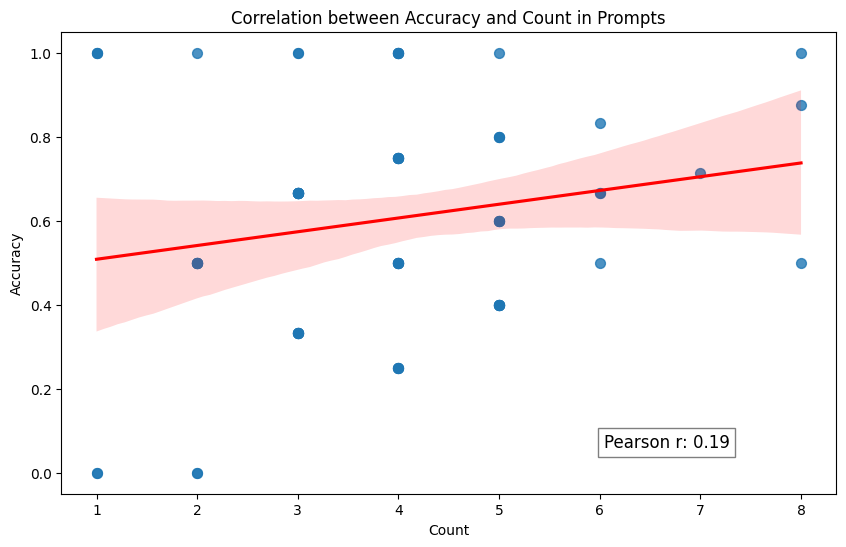

In [67]:
# Calculate the Pearson correlation coefficient
pearson_corr, p_value = pearsonr(accuracy_per_prompt['count'], accuracy_per_prompt['accuracy'])
print(f"Pearson correlation: {pearson_corr}, p-value: {p_value}")

# Plot the correlation between accuracy and count
plt.figure(figsize=(10, 6))
sns.regplot(x='count', y='accuracy', data=accuracy_per_prompt, scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.title('Correlation between Accuracy and Count in Prompts')
plt.xlabel('Count')
plt.ylabel('Accuracy')

# Annotate the plot with the Pearson correlation coefficient
plt.annotate(f'Pearson r: {pearson_corr:.2f}', xy=(0.7, 0.1), xycoords='axes fraction', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.show()

number of unique prompts: 74
Chi-Square Statistic: 47.777385159010606, p-value: 0.9902335136057456


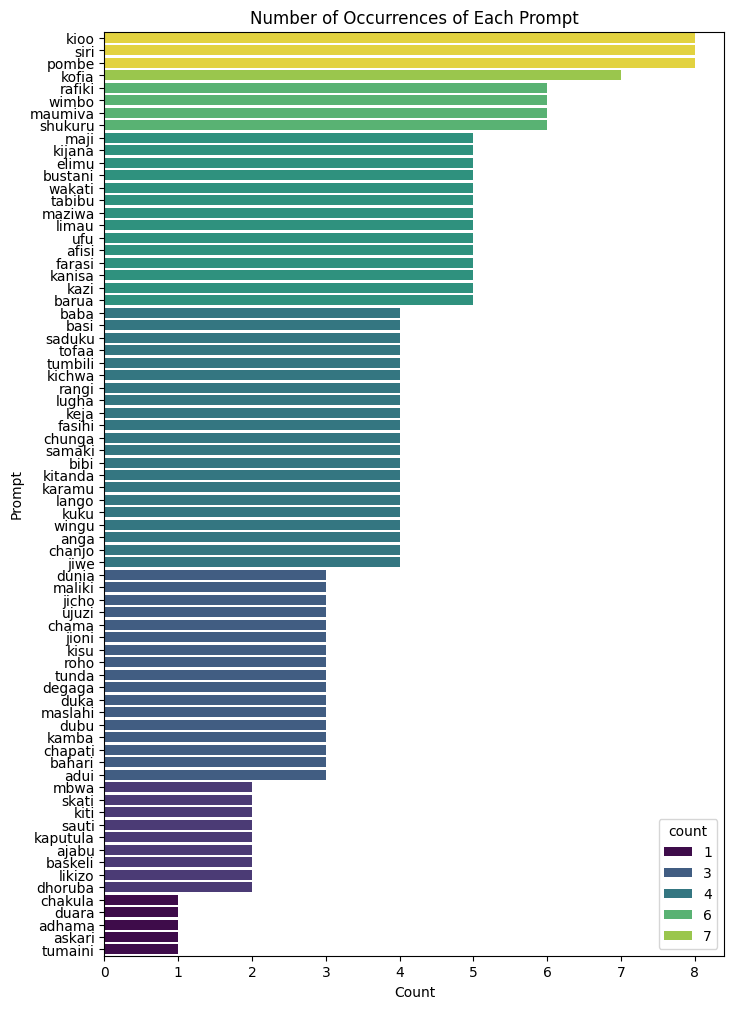

In [68]:
# Count the occurrences of each prompt in combined_data
prompt_counts = combined_data['prompt'].value_counts().reset_index()
prompt_counts.columns = ['prompt', 'count']

print(f"number of unique prompts: {len(prompt_counts)}")

# Perform the Chi-Square goodness-of-fit test
chi2_stat, p_value = chisquare(prompt_counts['count'])

print(f"Chi-Square Statistic: {chi2_stat}, p-value: {p_value}")

# Plot the number of occurrences of each prompt
plt.figure(figsize=(8, 12))
sns.barplot(x='count', y='prompt', data=prompt_counts, palette='viridis', hue='count')
plt.title('Number of Occurrences of Each Prompt')
plt.xlabel('Count')
plt.ylabel('Prompt')
plt.show()

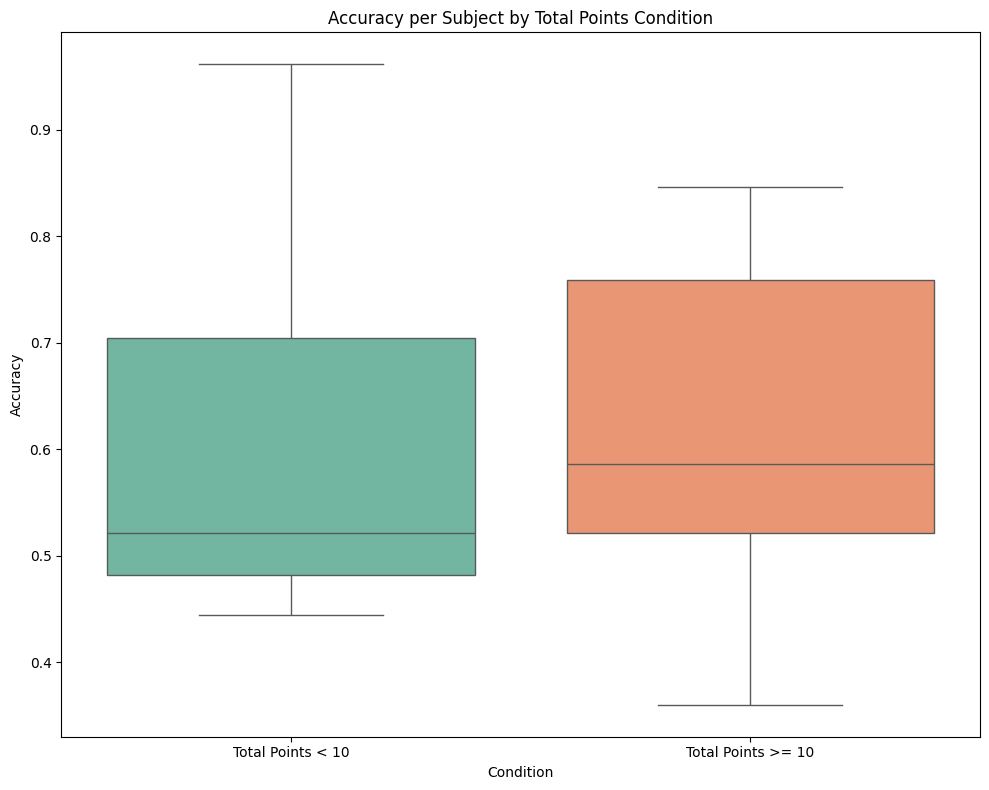

In [69]:
# Combine the data for both conditions
combined_accuracy = pd.concat([
    data_less_than_10.groupby('subject_number')['correct'].mean().reset_index().rename(columns={'correct': 'accuracy'}).assign(condition='Total Points < 10'),
    data_10_or_more.groupby('subject_number')['correct'].mean().reset_index().rename(columns={'correct': 'accuracy'}).assign(condition='Total Points >= 10')
])

# Create the boxplot
plt.figure(figsize=(10, 8))
sns.boxplot(x='condition', y='accuracy', data=combined_accuracy, palette='Set2', hue='condition')
plt.title('Accuracy per Subject by Total Points Condition')
plt.xlabel('Condition')
plt.ylabel('Accuracy')

# Show the plot
plt.tight_layout()
plt.show()


# complex models (Please read the following!!!):
I have added some outputs of some tests on the recall test data. Not sure if it needed, but maybe someone sees some value in it.

It contains the output of a LLM (claud.ai) suggesting the following tests (the code is adjusted to our data):
- mixed-effects logistic regression for accuracy
- linear mixed-effects model for reaction time
- correlation reaction time, accuracy (correct), total_points (sum of ADHD test questionnaire), length of the correct answer.
- repeated measures ANOVA
- logistic regression
    - I think the model is kinda able to predict whether the participant is correct or not?

In [70]:
# Copy the dataframe
combined_data_copy = combined_data.copy()

# Fit a mixed effects model
combined_data_copy['correct'] = combined_data_copy['correct'].astype(int)

model = smf.mixedlm("correct ~ time_bar_visible + total_points + C(trial_num)", 
                    data=combined_data_copy, 
                    groups=combined_data_copy["subject_number"])
result = model.fit()

print(result.summary())

# Odds ratios
odds_ratios = np.exp(result.params)
print("\nOdds Ratios:")
print(odds_ratios)

# Confidence intervals for odds ratios
conf_int = np.exp(result.conf_int())
print("\nConfidence Intervals for Odds Ratios:")
print(conf_int)

               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     correct  
No. Observations:     283         Method:                 REML     
No. Groups:           11          Scale:                  0.2035   
Min. group size:      21          Log-Likelihood:         -202.2372
Max. group size:      29          Converged:              Yes      
Mean group size:      25.7                                         
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.718    0.255  2.812 0.005  0.218  1.219
time_bar_visible[T.True] -0.084    0.055 -1.524 0.128 -0.192  0.024
C(trial_num)[T.2]         0.226    0.202  1.119 0.263 -0.170  0.622
C(trial_num)[T.3]        -0.071    0.202 -0.350 0.726 -0.467  0.325
C(trial_num)[T.4]         0.141    0.197  0.717 0.474 -0.245  0

In [71]:
# Assuming 'df' is your DataFrame
model_rt = smf.mixedlm("rt ~ time_bar_visible + total_points + C(trial_num)", 
                       data=combined_data_copy, 
                       groups=combined_data_copy["subject_number"])
result_rt = model_rt.fit()

print(result_rt.summary())

                   Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      rt           
No. Observations:        283          Method:                  REML         
No. Groups:              11           Scale:                   11343161.1860
Min. group size:         21           Log-Likelihood:          -2445.3938   
Max. group size:         29           Converged:               Yes          
Mean group size:         25.7                                               
----------------------------------------------------------------------------
                           Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
----------------------------------------------------------------------------
Intercept                  2352.334 1455.578  1.616 0.106  -500.547 5205.214
time_bar_visible[T.True]    549.184  409.621  1.341 0.180  -253.659 1352.028
C(trial_num)[T.2]         -2630.452 1508.144 -1.744 0.081 -5586.359  325.456
C(trial_num)[T.3]  

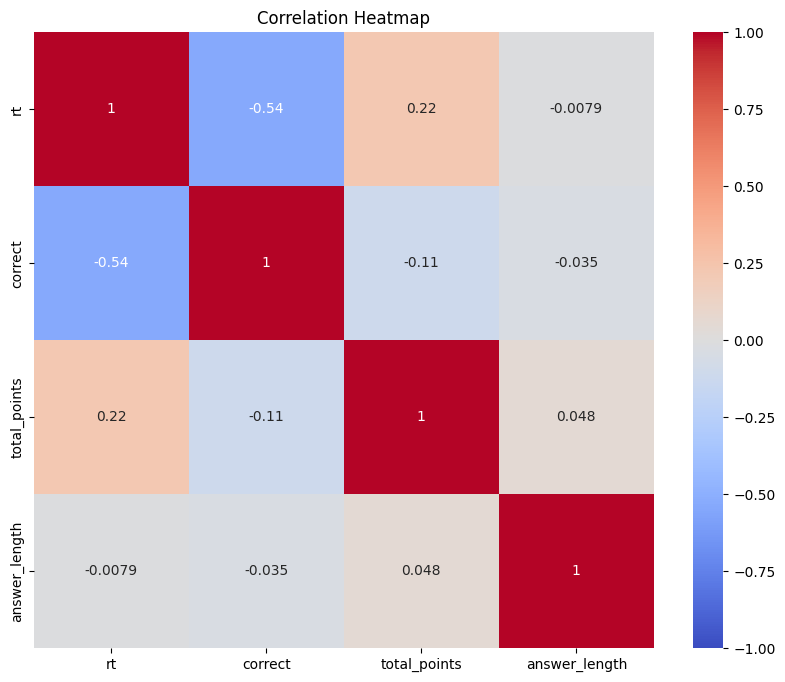

In [72]:
# Select relevant columns
corr_data = combined_data[['rt', 'correct', 'total_points', 'answer_length']]

# Compute correlation matrix
corr_matrix = corr_data.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap')
plt.show()

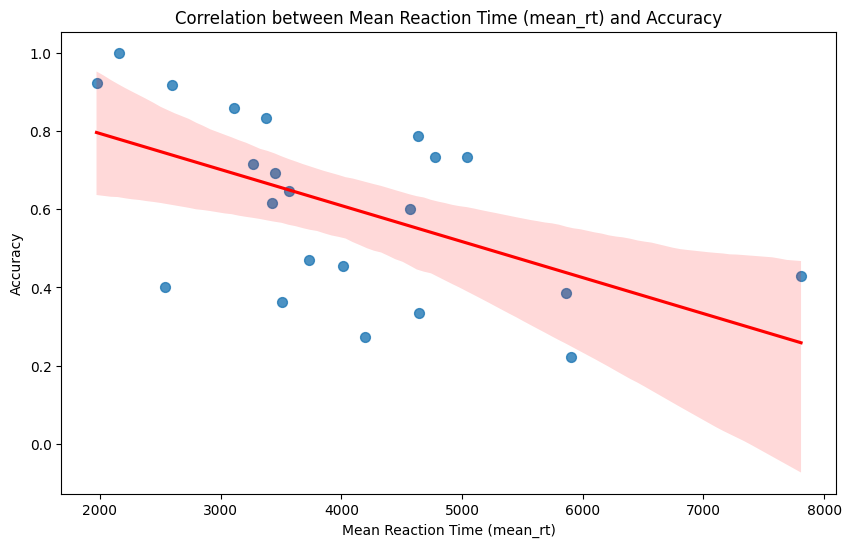

Pearson correlation: -0.5456472405587118, p-value: 0.008621967743714218


In [73]:
# Plot the correlation
plt.figure(figsize=(10, 6))
sns.regplot(x='mean_rt', y='accuracy', data=evals, scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.title('Correlation between Mean Reaction Time (mean_rt) and Accuracy')
plt.xlabel('Mean Reaction Time (mean_rt)')
plt.ylabel('Accuracy')
plt.show()

# Calculate the correlation using Pearson's correlation coefficient
pearson_corr_mean_rt_accuracy, p_value_mean_rt_accuracy = pearsonr(evals['mean_rt'], evals['accuracy'])
print(f"Pearson correlation: {pearson_corr_mean_rt_accuracy}, p-value: {p_value_mean_rt_accuracy}")

In [74]:
# Aggregate data by subject and condition
agg_data = combined_data.groupby(['subject_number', 'time_bar_visible'])['correct'].mean().unstack()

# Perform repeated measures ANOVA
f_statistic, p_value = stats.f_oneway(agg_data[True], agg_data[False])

print(f"F-statistic: {f_statistic}")
print(f"p-value: {p_value}")

F-statistic: 1.3067720556066371
p-value: 0.26647961059965347


In [75]:
# Aggregate data by subject
subject_data = combined_data.groupby('subject_number').agg({
    'correct': 'mean',
    'rt': 'mean',
    'total_points': 'first'
})

# Create binary ADHD classification (example threshold)
subject_data['adhd'] = (subject_data['total_points'] > 9).astype(int)

# Check the distribution of the target variable
print(subject_data['adhd'].value_counts())

# Adjust the threshold if necessary to ensure both classes are present
if subject_data['adhd'].nunique() < 2:
    subject_data['adhd'] = (subject_data['total_points'] > 10).astype(int)
subject_data['adhd'] = (subject_data['total_points'] > 9).astype(int)

X = subject_data[['correct', 'rt']]
y = subject_data['adhd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


adhd
0    6
1    5
Name: count, dtype: int64
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.50      1.00      0.67         1

    accuracy                           0.67         3
   macro avg       0.75      0.75      0.67         3
weighted avg       0.83      0.67      0.67         3

